# RoBERTa Model

### Import utilities

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import re

from collections import Counter

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from collections import Counter 
nltk.download('punkt_tab')


nltk.download('stopwords') 

plt.style.use('ggplot')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Open file to remove potential errors
with open('/teamspace/studios/this_studio/PROJECT_FINAL/data/dataset.csv', 'r', encoding='utf-8', errors='replace') as f:
    content = f.read()

# Save cleaned 
with open('/teamspace/studios/this_studio/PROJECT_FINAL/data/file_dataset.csv', 'w', encoding='utf-8') as f:
    f.write(content)

In [5]:
data = pd.read_csv('/teamspace/studios/this_studio/PROJECT_FINAL/data/file_dataset.csv').drop(columns='Unnamed: 0')

In [6]:
data.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,ratings
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2024-12-31,Why does it look like someone spit on my food?...,1
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-03-26,It'd McDonalds. It is what it is as far as the...,4
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-03-26,Made a mobile order got to the speaker and che...,1
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-02-28,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-01-31,"I repeat my order 3 times in the drive thru, a...",1


In [7]:
df = data.copy()

# Drop null values
df = df.dropna()

In [8]:
# Feature engineering City and State
df[['City', 'State']] = df['store_address'].apply(lambda x: pd.Series(x.split(', ')[-3:-1]))

In [9]:
# Create function to remove texts in the review column
def clean_review(review):
    review = review.lower()
    review = review.replace('½ï', '').replace('ý', '')
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = re.sub(r'\s+', ' ', review).strip()
    return review

df['clean_reviews'] = df['review'].apply(clean_review)

print(df[['clean_reviews']])

                                           clean_reviews
0      why does it look like someone spit on my food ...
1      itd mcdonalds it is what it is as far as the f...
2      made a mobile order got to the speaker and che...
3      my mc crispy chicken sandwich was customer ser...
4      i repeat my order times in the drive thru and ...
...                                                  ...
33391                         they treated me very badly
33392                           the service is very good
33393                         to remove hunger is enough
33394   its good but lately it has become very expensive
33395                          they took good care of me

[32309 rows x 1 columns]


In [10]:
# Function to add column for the actual review: positive : ratings > 3,
# neutral: ratings == 3, negative : ratings <3.
def actual_review(data):
    if data['ratings'] > 3:
        return "positive" 
    elif data["ratings"] == 3:
        return "neutral"
    else:
        return "negative"

# Apply the function to each row
df['actual_review'] = df.apply(actual_review, axis=1)

In [11]:
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,ratings,City,State,clean_reviews,actual_review
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2024-12-31,Why does it look like someone spit on my food?...,1,Austin,TX 78750,why does it look like someone spit on my food ...,negative
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-03-26,It'd McDonalds. It is what it is as far as the...,4,Austin,TX 78750,itd mcdonalds it is what it is as far as the f...,positive
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-03-26,Made a mobile order got to the speaker and che...,1,Austin,TX 78750,made a mobile order got to the speaker and che...,negative
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-02-28,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,Austin,TX 78750,my mc crispy chicken sandwich was customer ser...,positive
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-01-31,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX 78750,i repeat my order times in the drive thru and ...,negative


## Quick EDA

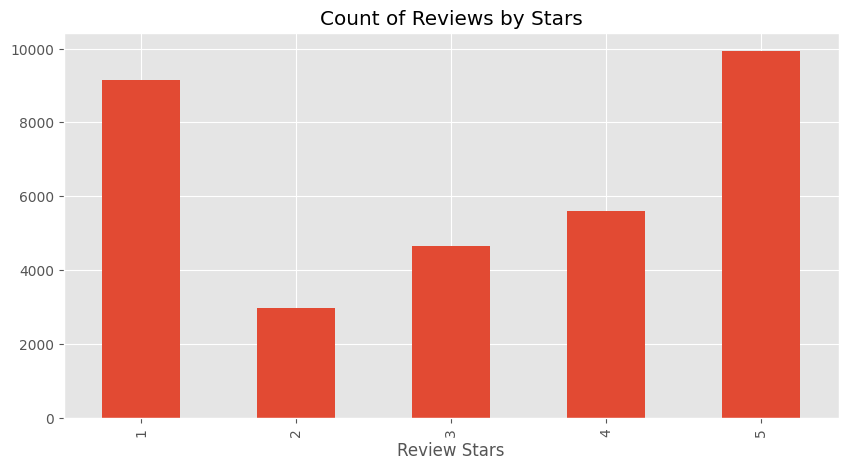

In [12]:
ax = df['ratings'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# Load RoBERTa Pretrained Model

    - Use a model trained of a large corpus of data.
    - Transformer model accounts for the words but also the context related to other words.


In [13]:
# Load model 
from transformers import pipeline

# Initialize the sentiment analysis pipeline
model_roberta = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use cpu


In [14]:
# Use model to analyze reviews of Mcdonald's restaurants in New York
df1 = df.copy(deep=True)
df_newyork=df1[df1["City"]=="New York"]

In [15]:
# Create dataframe of review_id, review, ratings, actual_review
df_newyork=df_newyork[['reviewer_id','clean_reviews','ratings','actual_review']]

In [16]:
df_newyork.head()

,reviewer_id,clean_reviews,ratings,actual_review
2968,2969,visited this location for breakfast the place ...,3,neutral
2969,2970,from cleanliness to freshness to the fast cust...,5,positive
2970,2971,mcdonalds was great the food tastes like in uk...,5,positive
2971,2972,thursday at am i went in here to order a very ...,1,negative
2972,2973,it is a hr location when i arrived and tried t...,1,negative


In [17]:
# Loop to each review in the dataset, the results are stored in a dictionary
res = {}
for i, row in tqdm(df_newyork.iterrows(), total=len(df_newyork)):
    try:
        text = row['clean_reviews']
        myid = row['reviewer_id']

        roberta_result = model_roberta(text)
        roberta_result_model = {}

        if isinstance(roberta_result, list) and len(roberta_result) > 0:
            for key, value in roberta_result[0].items():
                roberta_result_model[f'RoBerta_{key}'] = value

        res[myid] = roberta_result_model

    except RuntimeError:
        print(f'Runtime error for id {myid}')

  0%|          | 0/3452 [00:00<?, ?it/s]

In [18]:
# Convert the results in dictionary to pandas DataFrame
results = pd.DataFrame(res).T
results.head()

,RoBerta_label,RoBerta_score
2969,LABEL_2,0.76062
2970,LABEL_2,0.829798
2971,LABEL_2,0.987244
2972,LABEL_0,0.950658
2973,LABEL_0,0.827604


In [19]:
results= results.reset_index().rename(columns={'index': 'reviewer_id'})
results.head()

,reviewer_id,RoBerta_label,RoBerta_score
0,2969,LABEL_2,0.76062
1,2970,LABEL_2,0.829798
2,2971,LABEL_2,0.987244
3,2972,LABEL_0,0.950658
4,2973,LABEL_0,0.827604


In [20]:
# Merge the results dataframe to the main dataframe of Mcdonalds Newyork
results = results.merge(df_newyork, how='left')
results.head()

,reviewer_id,RoBerta_label,RoBerta_score,clean_reviews,ratings,actual_review
0,2969,LABEL_2,0.76062,visited this location for breakfast the place ...,3,neutral
1,2970,LABEL_2,0.829798,from cleanliness to freshness to the fast cust...,5,positive
2,2971,LABEL_2,0.987244,mcdonalds was great the food tastes like in uk...,5,positive
3,2972,LABEL_0,0.950658,thursday at am i went in here to order a very ...,1,negative
4,2973,LABEL_0,0.827604,it is a hr location when i arrived and tried t...,1,negative


In [21]:
# RoBERTa labeled results as: for negative review as LABEL_0, for neutral as LABEL_1, and for positive as LABEL_2
# Below is to map  the Labels as negative , neutral and positive

def map_roberta_labels(label):
    if label == 'LABEL_0':
        return 'negative'
    elif label == 'LABEL_1':
        return 'neutral'
    elif label == 'LABEL_2':
        return 'positive'
    else:
        return 'unknown' 

# Apply the function to the 'RoBerta_label' column
results['predicted_sentiment'] = results['RoBerta_label'].apply(map_roberta_labels)

In [22]:
df_results =results[['reviewer_id', 'clean_reviews', 'RoBerta_label', 'predicted_sentiment']]

In [ ]:
# Merge results
df_results = df_results.merge(results, how='left')
df_results.head()

,reviewer_id,clean_reviews,RoBerta_label,predicted_sentiment,RoBerta_score,ratings,actual_review
0,2969,visited this location for breakfast the place ...,LABEL_2,positive,0.76062,3,neutral
1,2970,from cleanliness to freshness to the fast cust...,LABEL_2,positive,0.829798,5,positive
2,2971,mcdonalds was great the food tastes like in uk...,LABEL_2,positive,0.987244,5,positive
3,2972,thursday at am i went in here to order a very ...,LABEL_0,negative,0.950658,1,negative
4,2973,it is a hr location when i arrived and tried t...,LABEL_0,negative,0.827604,1,negative


In [24]:
df_results['clean_reviews'][4]

'it is a hr location when i arrived and tried to order use the restroom i was told the restroom was closed i said i will order right after my use of the restroom but they still rejected with rude attitude i already told them im having shivers and can'

In [25]:
df_results['RoBerta_score'] = df_results['RoBerta_score'].astype(float)

In [ ]:
df_results.describe(include='all')

,reviewer_id,clean_reviews,RoBerta_label,predicted_sentiment,RoBerta_score,ratings,actual_review
count,3452.000000,3452,3452,3452,3452.000000,3452.000000,3452
unique,NaN,2608,3,3,NaN,NaN,3
top,NaN,excellent,LABEL_2,positive,NaN,NaN,positive
freq,NaN,290,1562,1562,NaN,NaN,1769
mean,4955.285921,NaN,NaN,NaN,0.779393,3.307937,NaN
std,1380.406651,NaN,NaN,NaN,0.174191,1.496801,NaN
min,2969.000000,NaN,NaN,NaN,0.360394,1.000000,NaN
25%,3839.750000,NaN,NaN,NaN,0.628040,2.000000,NaN
50%,4707.500000,NaN,NaN,NaN,0.833306,4.000000,NaN
75%,6144.250000,NaN,NaN,NaN,0.935812,5.000000,NaN


In [27]:
print(df_results[['RoBerta_score', 'predicted_sentiment', 'actual_review']].head(10))

   RoBerta_score predicted_sentiment actual_review
0       0.760620            positive       neutral
1       0.829798            positive      positive
2       0.987244            positive      positive
3       0.950658            negative      negative
4       0.827604            negative      negative
5       0.907027            negative      negative
6       0.684998            negative      negative
7       0.957730            positive      positive
8       0.754097            negative      negative
9       0.974456            negative      negative


In [28]:
# Function to calculate accuracy
def calculate_accuracy(predicted_labels, actual_labels):
    correct = 0
    total = 0
    for pred, actual in zip(predicted_labels, actual_labels):
        if pred is not None:  
            total += 1
            if pred.lower() == actual.lower():  
                correct += 1
    return correct / total if total > 0 else 0.0  

In [29]:
# Calculate accuracy
accuracy = calculate_accuracy(df_results['predicted_sentiment'], df_results['actual_review'])
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.75


In [30]:
df_results['correct_prediction'] = df_results.apply(
    lambda row: True if row['predicted_sentiment'] == row['actual_review'] else False,
    axis=1
)

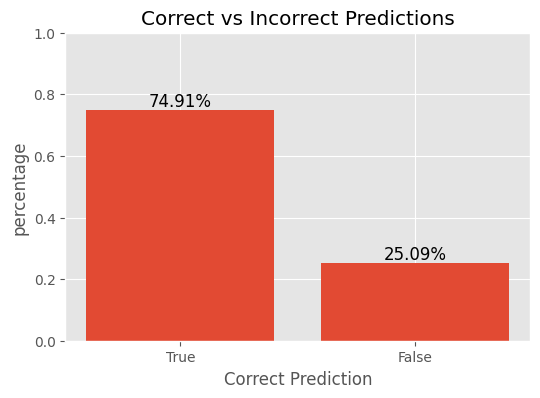

In [ ]:
# Calculate percentage
percentage = df_results['correct_prediction'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(percentage.index.astype(str), percentage.values)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2%}',
        ha='center', va='bottom', fontsize=12
    )

plt.xlabel('Correct Prediction')
plt.ylabel('percentage')
plt.title('Correct vs Incorrect Predictions')
plt.ylim(0, 1)
plt.show()


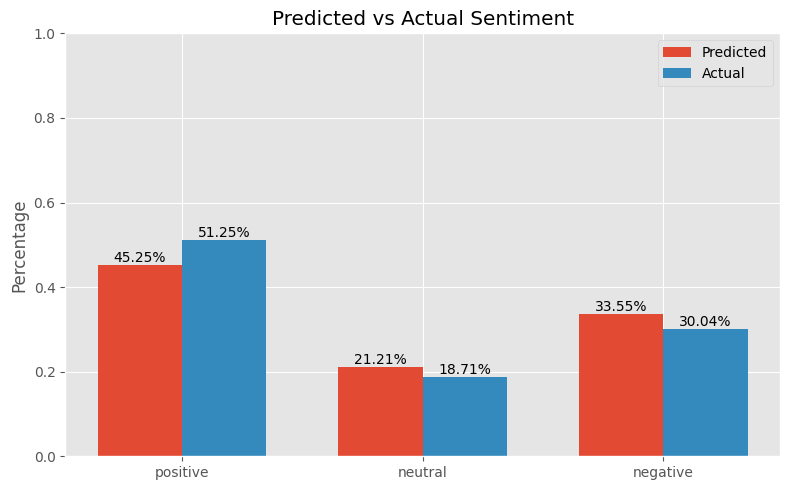

In [ ]:
# List of sentiments
sentiment = ['positive', 'neutral','negative']

# Calculation proportions
total_predicted = df_results['predicted_sentiment'].value_counts(normalize=True)
total_actual = df_results['actual_review'].value_counts(normalize=True)

predicted_props = [total_predicted.get(label, 0) for label in sentiment]
actual_props = [total_actual.get(label, 0) for label in sentiment]

# Bar
x = range(len(sentiment))
bar_width = 0.35

# Plot
plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - bar_width/2 for i in x], predicted_props, width=bar_width, label='Predicted')
bars2 = plt.bar([i + bar_width/2 for i in x], actual_props, width=bar_width, label='Actual')

# Add percentage labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=10
        )

plt.xticks(ticks=x, labels=sentiment)
plt.ylabel('Percentage')
plt.ylim(0, 1)
plt.title('Predicted vs Actual Sentiment')
plt.legend()
plt.tight_layout()
plt.show()


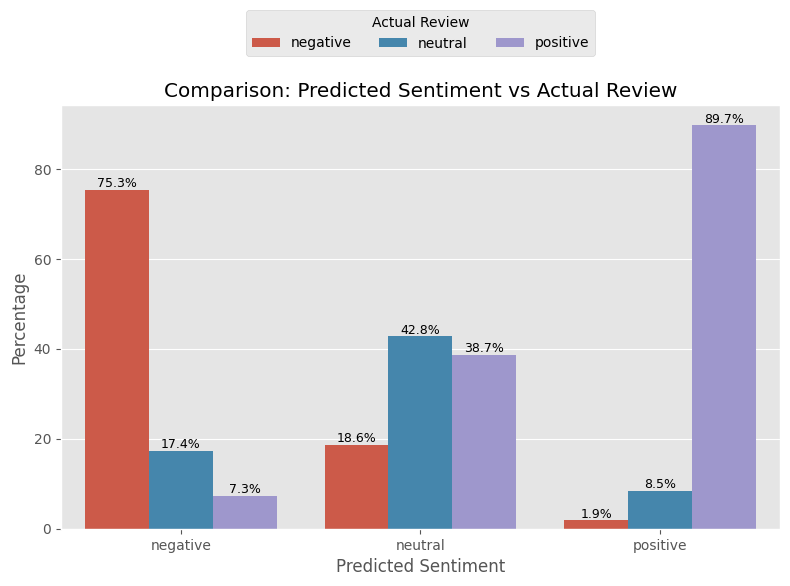

In [ ]:
df_results_filtered = df_results.copy()  

# Group and compute percentages
rates = df_results_filtered.groupby(['predicted_sentiment', 'actual_review']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert to long format
rates_long = rates.reset_index().melt(id_vars='predicted_sentiment', value_name='percentage', var_name='actual_review')

# Barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='predicted_sentiment', y='percentage', hue='actual_review')

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=9)

plt.title('Comparison: Predicted Sentiment vs Actual Review')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Percentage')
plt.legend(title='Actual Review', loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Make predictions on the whole dataset

In [34]:
df2 = df.copy(deep=True)

In [35]:
# Create dataframe of review_id, review, ratings, actual_review
df_whole_dataset=df2[['reviewer_id','clean_reviews','ratings','actual_review']]

In [36]:
# Loop to each review in the dataset, the results are stored in a dictionary
res = {}
for i, row in tqdm(df_whole_dataset.iterrows(), total=len(df_whole_dataset)):
    try:
        text = row['clean_reviews']
        myid = row['reviewer_id']

        roberta_result = model_roberta(text)
        roberta_result_model = {}

        if isinstance(roberta_result, list) and len(roberta_result) > 0:
            for key, value in roberta_result[0].items():
                roberta_result_model[f'RoBerta_{key}'] = value

        res[myid] = roberta_result_model

    except RuntimeError:
        print(f'Runtime error for id {myid}')

  0%|          | 0/32309 [00:00<?, ?it/s]

Runtime error for id 17317
Runtime error for id 23022
Runtime error for id 23690
Runtime error for id 27956
Runtime error for id 28804


In [37]:
# Convert the results in dictionary to pandas DataFrame
results_df = pd.DataFrame(res).T
results_df.head()

,RoBerta_label,RoBerta_score
1,LABEL_0,0.975279
2,LABEL_2,0.973995
3,LABEL_0,0.775205
4,LABEL_2,0.901184
5,LABEL_0,0.937037


In [38]:
results_df= results_df.reset_index().rename(columns={'index': 'reviewer_id'})
results_df.head()


,reviewer_id,RoBerta_label,RoBerta_score
0,1,LABEL_0,0.975279
1,2,LABEL_2,0.973995
2,3,LABEL_0,0.775205
3,4,LABEL_2,0.901184
4,5,LABEL_0,0.937037


In [39]:
# Merge the results dataframe to the main dataframe of Mcdonalds Newyork
results_df = results_df.merge(df_whole_dataset, how='left')
results_df.head()


,reviewer_id,RoBerta_label,RoBerta_score,clean_reviews,ratings,actual_review
0,1,LABEL_0,0.975279,why does it look like someone spit on my food ...,1,negative
1,2,LABEL_2,0.973995,itd mcdonalds it is what it is as far as the f...,4,positive
2,3,LABEL_0,0.775205,made a mobile order got to the speaker and che...,1,negative
3,4,LABEL_2,0.901184,my mc crispy chicken sandwich was customer ser...,5,positive
4,5,LABEL_0,0.937037,i repeat my order times in the drive thru and ...,1,negative


In [40]:
# Apply the function to the 'RoBerta_label' column
results_df['predicted_sentiment'] = results_df['RoBerta_label'].apply(map_roberta_labels)


In [41]:
# Create dataframe to just review the clean_reviews, Roberta label and precidected sentiment
df_results2 =results_df[['reviewer_id', 'clean_reviews', 'RoBerta_label', 'predicted_sentiment']]


In [42]:
# Merge results
df_results2 = df_results2.merge(results_df, how='left')
df_results2.head()


,reviewer_id,clean_reviews,RoBerta_label,predicted_sentiment,RoBerta_score,ratings,actual_review
0,1,why does it look like someone spit on my food ...,LABEL_0,negative,0.975279,1,negative
1,2,itd mcdonalds it is what it is as far as the f...,LABEL_2,positive,0.973995,4,positive
2,3,made a mobile order got to the speaker and che...,LABEL_0,negative,0.775205,1,negative
3,4,my mc crispy chicken sandwich was customer ser...,LABEL_2,positive,0.901184,5,positive
4,5,i repeat my order times in the drive thru and ...,LABEL_0,negative,0.937037,1,negative


In [43]:
print(df_results2[['RoBerta_score', 'predicted_sentiment', 'actual_review']].head(10))

  RoBerta_score predicted_sentiment actual_review
0      0.975279            negative      negative
1      0.973995            positive      positive
2      0.775205            negative      negative
3      0.901184            positive      positive
4      0.937037            negative      negative
5       0.88698            negative      negative
6      0.598395             neutral      negative
7      0.906189            negative      negative
8         0.983            positive      positive
9      0.847067            negative      negative


In [44]:
# Calculate accuracy using the calculate_accuracy funtion
accuracy = calculate_accuracy(df_results2['predicted_sentiment'], df_results2['actual_review'])
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.77


In [45]:
df_results2['correct_prediction'] = df_results2.apply(
    lambda row: True if row['predicted_sentiment'] == row['actual_review'] else False,
    axis=1
)

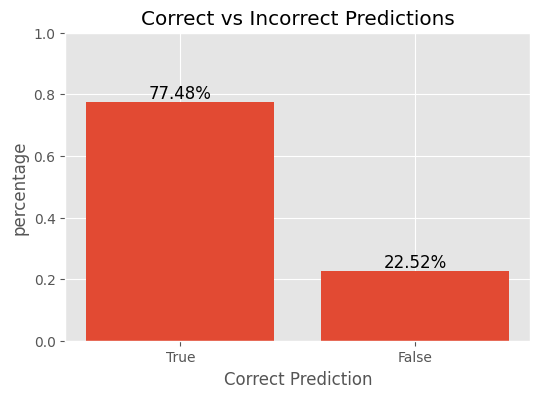

In [46]:
# Calculate percentage
percentage = df_results2['correct_prediction'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(percentage.index.astype(str), percentage.values)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2%}',
        ha='center', va='bottom', fontsize=12
    )

plt.xlabel('Correct Prediction')
plt.ylabel('percentage')
plt.title('Correct vs Incorrect Predictions')
plt.ylim(0, 1)
plt.show()


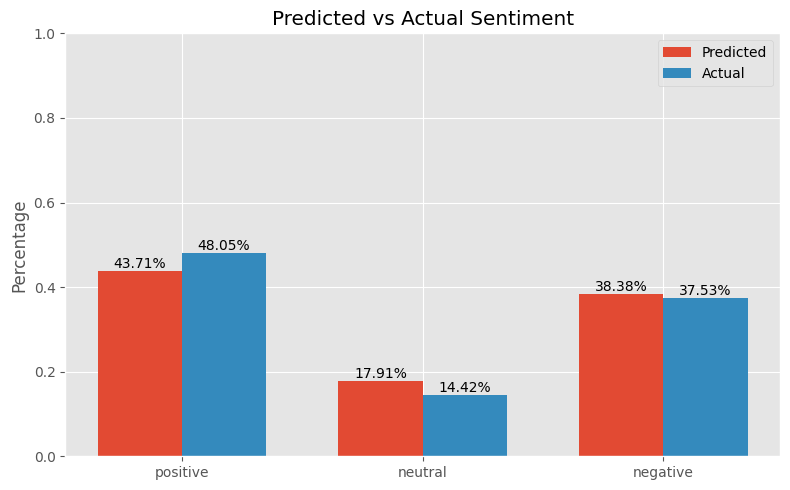

In [47]:
# List of sentiments
sentiment = ['positive', 'neutral','negative']

# Calculation proportions
total_predicted = df_results2['predicted_sentiment'].value_counts(normalize=True)
total_actual = df_results2['actual_review'].value_counts(normalize=True)

predicted_props = [total_predicted.get(label, 0) for label in sentiment]
actual_props = [total_actual.get(label, 0) for label in sentiment]

# Bar
x = range(len(sentiment))
bar_width = 0.35

# Plot
plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - bar_width/2 for i in x], predicted_props, width=bar_width, label='Predicted')
bars2 = plt.bar([i + bar_width/2 for i in x], actual_props, width=bar_width, label='Actual')

# Add percentage labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=10
        )

plt.xticks(ticks=x, labels=sentiment)
plt.ylabel('Percentage')
plt.ylim(0, 1)
plt.title('Predicted vs Actual Sentiment')
plt.legend()
plt.tight_layout()
plt.show()


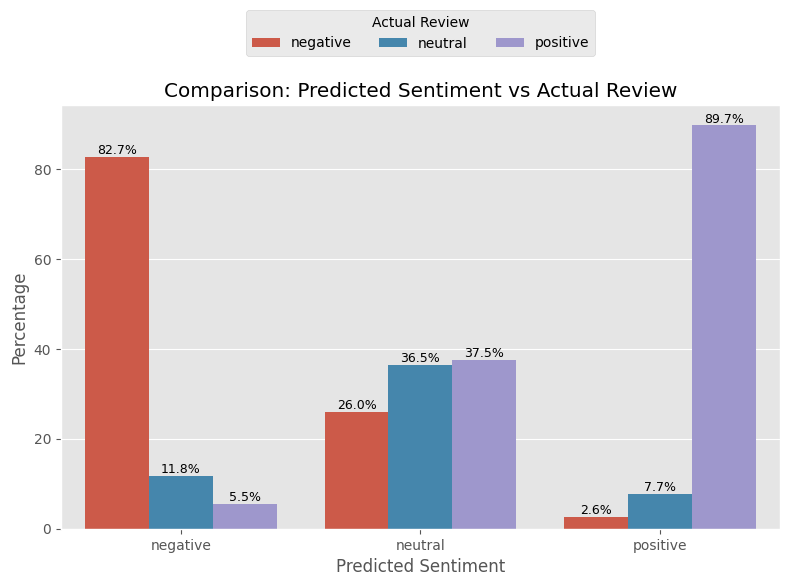

In [48]:
df_results_filtered2 = df_results2.copy()  

# Group and compute percentages
rates = df_refults_filtered2.groupby(['predicted_sentiment', 'actual_review']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert to long format
rates_long = rates.reset_index().melt(id_vars='predicted_sentiment', value_name='percentage', var_name='actual_review')

# Barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='predicted_sentiment', y='percentage', hue='actual_review')

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=9)

plt.title('Comparison: Predicted Sentiment vs Actual Review')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Percentage')
plt.legend(title='Actual Review', loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [62]:
# Merge results to the main dataset and remove the lines where errors occured on the prediction: 
df = df[~df['reviewer_id'].isin([17317,23022, 23690, 27956, 28804])]

In [70]:
# Merge results
df_results_merged = df_results_filtered2.merge(df, how='left')
df_results_merged.head()


,reviewer_id,clean_reviews,RoBerta_label,predicted_sentiment,RoBerta_score,ratings,actual_review,correct_prediction,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,City,State
0,1,why does it look like someone spit on my food ...,LABEL_0,negative,0.975279,1,negative,True,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2024-12-31,Why does it look like someone spit on my food?...,Austin,TX 78750
1,2,itd mcdonalds it is what it is as far as the f...,LABEL_2,positive,0.973995,4,positive,True,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-03-26,It'd McDonalds. It is what it is as far as the...,Austin,TX 78750
2,3,made a mobile order got to the speaker and che...,LABEL_0,negative,0.775205,1,negative,True,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-03-26,Made a mobile order got to the speaker and che...,Austin,TX 78750
3,4,my mc crispy chicken sandwich was customer ser...,LABEL_2,positive,0.901184,5,positive,True,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-02-28,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,Austin,TX 78750
4,5,i repeat my order times in the drive thru and ...,LABEL_0,negative,0.937037,1,negative,True,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2025-01-31,"I repeat my order 3 times in the drive thru, a...",Austin,TX 78750


In [71]:
# Drop unwanted columns
df_results_merged.drop(columns=['RoBerta_label', 'store_name', 'review','category', 'store_address', 'rating_count'], inplace=True)

In [72]:
df_results_merged.head()

,reviewer_id,clean_reviews,predicted_sentiment,RoBerta_score,ratings,actual_review,correct_prediction,latitude,longitude,review_time,City,State
0,1,why does it look like someone spit on my food ...,negative,0.975279,1,negative,True,30.460718,-97.792874,2024-12-31,Austin,TX 78750
1,2,itd mcdonalds it is what it is as far as the f...,positive,0.973995,4,positive,True,30.460718,-97.792874,2025-03-26,Austin,TX 78750
2,3,made a mobile order got to the speaker and che...,negative,0.775205,1,negative,True,30.460718,-97.792874,2025-03-26,Austin,TX 78750
3,4,my mc crispy chicken sandwich was customer ser...,positive,0.901184,5,positive,True,30.460718,-97.792874,2025-02-28,Austin,TX 78750
4,5,i repeat my order times in the drive thru and ...,negative,0.937037,1,negative,True,30.460718,-97.792874,2025-01-31,Austin,TX 78750


In [73]:
df_results_merged.to_csv('/teamspace/studios/this_studio/PROJECT_FINAL/data/model_roberta_results.csv')

# Find common words

In [40]:
# Load RoBERTa results
df_roberta= pd.read_csv('/teamspace/studios/this_studio/PROJECT_FINAL/data/model_roberta_results.csv').drop(columns='Unnamed: 0')

In [41]:
df_roberta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32304 entries, 0 to 32303
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   reviewer_id          32304 non-null  int64  
 1   clean_reviews        32257 non-null  object 
 2   predicted_sentiment  32304 non-null  object 
 3   RoBerta_score        32304 non-null  float64
 4   ratings              32304 non-null  int64  
 5   actual_review        32304 non-null  object 
 6   correct_prediction   32304 non-null  bool   
 7   latitude             32304 non-null  float64
 8   longitude            32304 non-null  float64
 9   review_time          32304 non-null  object 
 10  City                 32304 non-null  object 
 11  State                32304 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 2.7+ MB


In [46]:
# Remove Stopwords
def clean_review(review):
    if not isinstance(review, str): 
        return ""
    stop_words = set(stopwords.words('english'))
    stop_words.update(['mcdonalds', 'dont','go','got','good','one','always','people','get','like'])
    review_tokens = word_tokenize(review)
    filtered_review = ' '.join([word for word in review_tokens if word not in stop_words])

    return filtered_review

df_roberta['no_stop_words_review'] = df_roberta['clean_reviews'].apply(clean_review)

#print(df_roberta[['no_stop_words_review']])


In [47]:
df_roberta['word_list'] = df_roberta['no_stop_words_review'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df_roberta['word_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,food,7447
1,service,5980
2,order,5929
3,place,3231
4,drive,2777
5,fast,2603
6,time,2504
7,excellent,2496
8,staff,2314
9,great,2221


## Common words in negative and positive reviews

In [49]:
positive = df_roberta[df_roberta['predicted_sentiment'] == 'positive']
negative = df_roberta[df_roberta['predicted_sentiment'] == 'negative']

In [50]:
# Word count in positive reviews
top = Counter([item for sublist in df_roberta[df_roberta['predicted_sentiment'] == 'positive']['word_list'] for item in sublist])
positive_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
positive_words.style.background_gradient(cmap='Greens')

,Common_words,count
0,food,2982
1,service,2776
2,excellent,2464
3,great,1944
4,fast,1664
5,place,1450
6,clean,1411
7,nice,1219
8,friendly,1112
9,order,1092


In [51]:
positive_words.to_csv('/teamspace/studios/this_studio/PROJECT_FINAL/data/positive_words.csv')

In [52]:
# Word count in negative reviews
top = Counter([item for sublist in df_roberta[df_roberta['predicted_sentiment'] == 'negative']['word_list'] for item in sublist])
negative_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
negative_words.style.background_gradient(cmap='Reds')

,Common_words,count
0,order,4240
1,food,3646
2,service,2871
3,drive,1778
4,place,1549
5,time,1544
6,minutes,1403
7,manager,1221
8,rude,1213
9,never,1179


In [53]:
negative_words.to_csv('/teamspace/studios/this_studio/PROJECT_FINAL/data/negative_words.csv')

## Top 5 comments in negative and positive reviews

In [71]:
# Top 5 positive reviews

positive_reviews = df_roberta[df_roberta['predicted_sentiment'] == 'positive']

top_5_positive_df = positive_reviews.sort_values(by='RoBerta_score', ascending=False).head(5)
top_5_positive_df = top_5_positive_df.reset_index(drop=True)

print(top_5_positive_df[['reviewer_id', 'clean_reviews','actual_review']])

   reviewer_id                                      clean_reviews  \
0         1957  my son and i love coming here amazing staff fo...   
1          101  i love going to mcdonalds in that area because...   
2        14045  i love coming to this mcdonalds leon springs t...   
3         7823  thanks for the perfect iced coffee i got the p...   
4        26744  i am so happy and glad that they finally reope...   

  actual_review  
0      positive  
1      positive  
2      positive  
3      positive  
4      positive  


In [70]:
# Top 5 negative reviews

negative_reviews = df_roberta[df_roberta['predicted_sentiment'] == 'negative']

top_5_negative_df = negative_reviews.sort_values(by='RoBerta_score', ascending=False).head(5)
top_5_negative_df = top_5_negative_df.reset_index(drop=True)

print(top_5_negative_df[['reviewer_id', 'clean_reviews','actual_review']])

   reviewer_id                                      clean_reviews  \
0         8754  this mcds sucks their food is disgusting and t...   
1        12677  this mcdonalds is one of the worst mcdonalds i...   
2        11246  seriously this mcdonalds is the worst ive ever...   
3          822  horrible customer service came here for breakf...   
4        30333  this place deserves no stars my order which wa...   

  actual_review  
0      negative  
1      negative  
2      negative  
3      negative  
4      negative  
